 LIBRERIAS

In [49]:
import os
import pandas as pd
import re

BASE DE DATOS

In [2]:
df = pd.read_excel(r"D:\Proyecto_proyección_estados\0. Maestra\BASE_MAESTRA AJUSTADA_15102025.xlsx")

Supuesto sobre JE3 su cierre en 20252 es igual a su inicio

In [51]:
cond = df["CONVOCATORIA"] == "JE3"
df.loc[cond, "ESTADO_20252_CIERRE"] = df.loc[cond, "ESTADO_20252_INICIO"]


PROCESAMIENTO

In [52]:
df_activos = df[df["CUPO"] == "ACTIVO"].copy()

In [53]:
periodos = ["ESTADO_20212_INICIO",	
            "ESTADO_20212_CIERRE",
            "ESTADO_20221_INICIO",
            "ESTADO_20221_CIERRE",
            "ESTADO_20222_INICIO",	
            "ESTADO_20222_CIERRE",
            "ESTADO_20231_INICIO",	
            "ESTADO_20231_CIERRE",
            "ESTADO_20232_INICIO",	
            "ESTADO_20232_CIERRE",
            "ESTADO_20241_INICIO",	
            "ESTADO_20241_CIERRE",
            "ESTADO_20242_INICIO",
            "ESTADO_20242_CIERRE",
            "ESTADO_20251_INICIO",
            "ESTADO_20251_CIERRE",
            "ESTADO_20252_INICIO",	
            "ESTADO_20252_CIERRE"]

Esto es nuevo

In [54]:
# Extraer los valores únicos de todas esas columnas
estados_unicos = pd.unique(df_activos[periodos].values.ravel())

# Quitar nulos/NaN y ordenar alfabéticamente
estados_unicos = sorted([str(e) for e in estados_unicos if pd.notna(e)])

estados_unicos

['ABANDONO DE FORMACION',
 'ABANDONO DE FORMACION ',
 'APLAZADO',
 'APLAZAMIENTO ADICIONAL',
 'APLAZAMIENTO EXTEMPORANEO',
 'APLAZAMIENTO INSTITUCIONAL',
 'EN VERIFICACION',
 'FALLECIDO',
 'GRADUADO',
 'MATRICULADO',
 'MATRICULADO BECA IES',
 'NO APLICA',
 'PERDIDA DEL BENEFICIO',
 'SIN BOLSA DE CREDITOS',
 'SIN RENOVACION',
 'TERMINACION DE MATERIAS',
 'TRASLADO IES']

In [55]:
reemplazar = {
    'ABANDONO DE FORMACION':"Abandono",
    'ABANDONO DE FORMACION ':"Abandono",
    'APLAZADO': "Aplazado",
    'APLAZAMIENTO ADICIONAL': "Aplazado",
    'APLAZAMIENTO EXTEMPORANEO': "Aplazado",
    'APLAZAMIENTO INSTITUCIONAL': "Aplazado",
    'EN VERIFICACION': "En Verificacion",
    'FALLECIDO': "Abandono",
    'GRADUADO': "Graduado",
    'MATRICULADO': "Matriculado",
    'MATRICULADO BECA IES': "Matriculado",
    'NO APLICA': "No aplica",
    'PERDIDA DEL BENEFICIO': "Pérdida del Beneficio",
    'SIN BOLSA DE CREDITOS': "Sin bolsa de creditos",
    'SIN RENOVACION': "Abandono",
    'SON BOLSA DE CREDITOS': "Sin bolsa de creditos",
    'TERMINACION DE MATERIAS': "Graduado",
    'TRASLADO IES': "Abandono",
    'FINALIZACIÓN 100%':"Graduado"}

In [56]:
# Reemplazo en todas las columnas de periodos
df_activos[periodos] = df_activos[periodos].replace(reemplazar)

# Opcional: verificar los valores únicos después del reemplazo
for col in periodos:
    print(col, sorted(df_activos[col].dropna().unique()))

ESTADO_20212_INICIO ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
ESTADO_20212_CIERRE ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
ESTADO_20221_INICIO ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
ESTADO_20221_CIERRE ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
ESTADO_20222_INICIO ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
ESTADO_20222_CIERRE ['Abandono', 'Aplazado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio']
ESTADO_20231_INICIO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio']
ESTADO_20231_CIERRE ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio']
ESTADO_20232_INICIO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio', 'Sin bolsa de creditos']
ESTADO_20232_CIERRE ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio', 'Sin bolsa de creditos']
ESTADO_20241_INICIO ['Abandono', 'Aplazado', 'G

IMPUTAR CRÉDITOS PERDIDOS Y APROBADOS CON XGBOOST

NUEVAS VARIABLES

In [57]:
df_activos["%_PERDIDA"] = df_activos["ACU_CRED_PERDIDOS"] / df_activos["CREDITOS_PROGRAMA"]
df_activos["%_AVANCE_APROBACION"] = df_activos["ACU_CRED_APROBADOS"] / df_activos["CREDITOS_PROGRAMA"]

count    45615.000000
mean         0.051173
std          0.095390
min          0.000000
25%          0.000000
50%          0.012048
75%          0.058364
max          1.510204
Name: %_PERDIDA, dtype: float64


<Axes: >

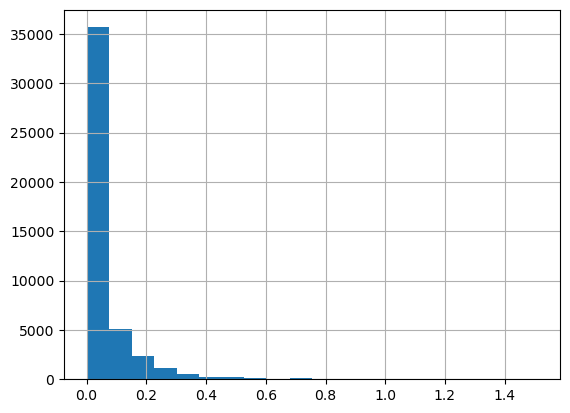

In [58]:
print(df_activos["%_PERDIDA"].describe())
df_activos["%_PERDIDA"].hist(bins=20)

count    44320.000000
mean         0.331437
std          0.230280
min          0.000000
25%          0.147348
50%          0.283333
75%          0.469819
max          3.020408
Name: %_AVANCE_APROBACION, dtype: float64


<Axes: >

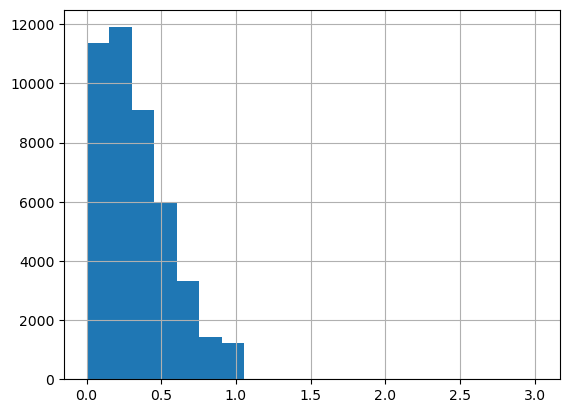

In [59]:
print(df_activos["%_AVANCE_APROBACION"].describe())
df_activos["%_AVANCE_APROBACION"].hist(bins=20)

In [60]:
nueva_variable_estado = {"20212_ESTADO":"ESTADO_20212_CIERRE",
                        "20221_ESTADO":"ESTADO_20221_CIERRE",
                        "20222_ESTADO":"ESTADO_20222_CIERRE",
                        "20231_ESTADO":"ESTADO_20231_CIERRE",
                        "20232_ESTADO":"ESTADO_20232_CIERRE",
                        "20241_ESTADO":"ESTADO_20241_CIERRE",
                        "20242_ESTADO":"ESTADO_20242_CIERRE",
                        "20251_ESTADO":"ESTADO_20251_CIERRE",
                        "20252_ESTADO":"ESTADO_20252_CIERRE"}

rename_dict = {v: k for k, v in nueva_variable_estado.items()}
df_activos = df_activos.rename(columns=rename_dict)

In [61]:
nueva_variable_estado_INICIO = {"20212_ESTADO_INICIO":"ESTADO_20212_INICIO",
                        "20221_ESTADO_INICIO":"ESTADO_20221_INICIO",
                        "20222_ESTADO_INICIO":"ESTADO_20222_INICIO",
                        "20231_ESTADO_INICIO":"ESTADO_20231_INICIO",
                        "20232_ESTADO_INICIO":"ESTADO_20232_INICIO",
                        "20241_ESTADO_INICIO":"ESTADO_20241_INICIO",
                        "20242_ESTADO_INICIO":"ESTADO_20242_INICIO",
                        "20251_ESTADO_INICIO":"ESTADO_20251_INICIO",
                        "20252_ESTADO_INICIO":"ESTADO_20252_INICIO"}

rename_dict = {v: k for k, v in nueva_variable_estado_INICIO.items()}
df_activos = df_activos.rename(columns=rename_dict)



In [62]:
def contar_estado_acumulado(df, columnas_estado, estado_objetivo, sufijo="_N_"):

    acumulado = pd.Series(0, index=df.index)

    for col in columnas_estado:
        nueva_col = col.replace("_ESTADO", f"{sufijo}{estado_objetivo}")

        acumulado = acumulado + (df[col] == estado_objetivo).astype(int)
        df[nueva_col] = acumulado

    return df

In [63]:

cols_estado = ["20212_ESTADO", "20221_ESTADO", "20222_ESTADO",
               "20231_ESTADO", "20232_ESTADO", "20241_ESTADO",
               "20242_ESTADO", "20251_ESTADO", "20252_ESTADO"]

df_activos = contar_estado_acumulado(df_activos, cols_estado, "Matriculado")
df_activos = contar_estado_acumulado(df_activos, cols_estado, "Aplazado")
df_activos = contar_estado_acumulado(df_activos, cols_estado, "Abandono")
df_activos = contar_estado_acumulado(df_activos, cols_estado, "Sin bolsa de creditos")
df_activos = contar_estado_acumulado(df_activos, cols_estado, "Pérdida del Beneficio")
df_activos = contar_estado_acumulado(df_activos, cols_estado, "Graduado")

df_activos["N_Matriculas"] = df_activos["20251_N_Matriculado"]



In [64]:
N_Matriculas_adicionales = [
    "20212_N_Matriculas_adicionales",
    "20221_N_Matriculas_adicionales",
    "20222_N_Matriculas_adicionales",
    "20231_N_Matriculas_adicionales",
    "20232_N_Matriculas_adicionales",
    "20241_N_Matriculas_adicionales",
    "20242_N_Matriculas_adicionales",
    "20251_N_Matriculas_adicionales",
    "20252_N_Matriculas_adicionales"]


N_Matriculado = [
    "20212_N_Matriculado",
    "20221_N_Matriculado",
    "20222_N_Matriculado",
    "20231_N_Matriculado",
    "20232_N_Matriculado",
    "20241_N_Matriculado",
    "20242_N_Matriculado",
    "20251_N_Matriculado",
    "20252_N_Matriculado"]

# Calcular para cada periodo
for col_in, col_out in zip(N_Matriculado, N_Matriculas_adicionales):
    df_activos[col_out] = (df_activos[col_in] - df_activos["PERIODOS_BD_SNIES"]).clip(lower=0)

DISTRIBUCIÓN DE CRÉDITOS PERDIDOS RETROACTIVAMENTE

In [65]:


Distr_tecnico = {
    1:  [1.00],
    2:  [0.90, 1.00],
    3:  [0.75, 0.91, 1.00],
    4:  [0.70, 0.85, 0.94, 1.00],
    5:  [0.67, 0.81, 0.90, 0.95, 1.00],
    6:  [0.65, 0.78, 0.86, 0.92, 0.96, 1.00],
    7:  [0.63, 0.76, 0.84, 0.89, 0.94, 0.97, 1.00],
    8:  [0.61, 0.74, 0.82, 0.87, 0.91, 0.95, 0.98, 1.00],
    9:  [0.60, 0.73, 0.80, 0.85, 0.89, 0.93, 0.95, 0.98, 1.00],
    10: [0.59, 0.71, 0.79, 0.84, 0.88, 0.91, 0.94, 0.96, 0.98, 1.00],
    11: [0.58, 0.70, 0.77, 0.82, 0.86, 0.89, 0.92, 0.94, 0.96, 0.98, 1.00],
    12: [0.57, 0.69, 0.76, 0.81, 0.85, 0.88, 0.91, 0.93, 0.95, 0.97, 0.98, 1.00]
}

Distr_tecnologico = {
    1:  [1.00],
    2:  [0.46, 1.00],
    3:  [0.35, 0.76, 1.00],
    4:  [0.30, 0.65, 0.86, 1.00],
    5:  [0.27, 0.59, 0.77, 0.90, 1.00],
    6:  [0.25, 0.54, 0.71, 0.83, 0.92, 1.00],
    7:  [0.24, 0.51, 0.67, 0.78, 0.87, 0.94, 1.00],
    8:  [0.22, 0.48, 0.63, 0.74, 0.82, 0.89, 0.95, 1.00],
    9:  [0.21, 0.46, 0.61, 0.71, 0.79, 0.86, 0.91, 0.96, 1.00],
    10: [0.21, 0.45, 0.59, 0.68, 0.76, 0.82, 0.88, 0.92, 0.96, 1.00],
    11: [0.20, 0.43, 0.57, 0.66, 0.74, 0.80, 0.85, 0.89, 0.93, 0.97, 1.00],
    12: [0.19, 0.42, 0.55, 0.64, 0.72, 0.78, 0.83, 0.87, 0.91, 0.94, 0.97, 1.00],
    13: [0.19, 0.41, 0.54, 0.63, 0.70, 0.76, 0.80, 0.85, 0.88, 0.92, 0.95, 0.97, 1.00],
    14: [0.19, 0.40, 0.52, 0.61, 0.68, 0.74, 0.79, 0.83, 0.86, 0.90, 0.93, 0.95, 0.98, 1.00],
    15: [0.18, 0.39, 0.51, 0.60, 0.67, 0.72, 0.77, 0.81, 0.85, 0.88, 0.91, 0.93, 0.96, 0.98, 1.00],
    16: [0.18, 0.38, 0.50, 0.59, 0.66, 0.71, 0.75, 0.79, 0.83, 0.86, 0.89, 0.91, 0.94, 0.96, 0.98, 1.00]
}




Distr_universitario = {
    1:  [1.00],
    2:  [0.67, 1.00],
    3:  [0.56, 0.84, 1.00],
    4:  [0.50, 0.75, 0.90, 1.00],
    5:  [0.46, 0.69, 0.83, 0.93, 1.00],
    6:  [0.44, 0.65, 0.78, 0.87, 0.943, 1.00],
    7:  [0.42, 0.62, 0.75, 0.83, 0.90, 0.95, 1.00],
    8:  [0.40, 0.60, 0.72, 0.80, 0.86, 0.92, 0.96, 1.00],
    9:  [0.39, 0.58, 0.69, 0.77, 0.84, 0.89, 0.93, 0.97, 1.00],
    10: [0.38, 0.56, 0.67, 0.75, 0.81, 0.86, 0.90, 0.94, 0.97, 1.00],
    11: [0.37, 0.55, 0.66, 0.73, 0.79, 0.84, 0.88, 0.92, 0.95, 0.97, 1.00],
    12: [0.36, 0.54, 0.64, 0.72, 0.77, 0.82, 0.86, 0.90, 0.93, 0.95, 0.98, 1.00],
    13: [0.35, 0.53, 0.63, 0.70, 0.76, 0.80, 0.84, 0.88, 0.91, 0.93, 0.96, 0.98, 1.00],
    14: [0.35, 0.52, 0.62, 0.69, 0.74, 0.79, 0.83, 0.86, 0.89, 0.92, 0.94, 0.96, 0.98, 1.00],
    15: [0.34, 0.51, 0.61, 0.68, 0.73, 0.78, 0.81, 0.85, 0.88, 0.90, 0.92, 0.95, 0.97, 0.98, 1.00],
    16: [0.33, 0.50, 0.60, 0.67, 0.72, 0.76, 0.80, 0.83, 0.86, 0.89, 0.91, 0.93, 0.95, 0.97, 0.98, 1.00],
    17: [0.33, 0.49, 0.59, 0.66, 0.71, 0.75, 0.79, 0.82, 0.85, 0.87, 0.90, 0.92, 0.94, 0.95, 0.97, 0.99, 1.00],
    18: [0.32, 0.49, 0.58, 0.65, 0.70, 0.74, 0.78, 0.81, 0.84, 0.86, 0.88, 0.91, 0.92, 0.94, 0.96, 0.97, 0.99, 1.00]
}




In [66]:
def distribuir_perdida(df, periodos, col_matriculas, col_perdida, col_nivel, distr_universitario, distr_tecnologico, distr_tecnico):

    mapa_dicc = {
        "UNIVERSITARIO": distr_universitario,
        "TECNOLOGICO": distr_tecnologico,
        "FORMACION TECNICA PROFESIONAL": distr_tecnico
    }

    for per in periodos:
        col_nmat = f"{per}_N_Matriculado"
        col_out = f"{per}_%_PERD_CRED"

        def calcular_fila(row):
            n_mat = row[col_matriculas]
            if n_mat == 0 or pd.isna(n_mat):
                return 0

            nivel = row[col_nivel]
            if nivel not in mapa_dicc:
                return 0

            dicc = mapa_dicc[nivel]

            # Validar que exista clave en el diccionario
            if n_mat not in dicc:
                return 0

            lista_distrib = dicc[n_mat]

            # Buscar en la columna de N_Matriculado
            valor_n = row[col_nmat]
            if pd.isna(valor_n) or valor_n == 0:
                return 0

            # Índice: valor_n - 1
            idx = int(valor_n) - 1
            if idx < 0 or idx >= len(lista_distrib):
                return 0

            return row[col_perdida] * lista_distrib[idx]

        df[col_out] = df.apply(calcular_fila, axis=1)

    return df


In [67]:
periodos = ["20212","20221","20222","20231","20232","20241","20242","20251", "20252"]

df_activos = distribuir_perdida(
    df=df_activos,
    periodos=periodos,
    col_matriculas="N_Matriculas",
    col_perdida="%_PERDIDA",
    col_nivel="NIVEL_FORMACION",
    distr_universitario=Distr_universitario,
    distr_tecnologico=Distr_tecnologico,
    distr_tecnico=Distr_tecnico
)


DISTRIBUCIÓN DE CRÉDITOS APROBADOS RETROACTIVAMENTE

In [68]:
def acumular(n):
    if n <= 0:
        return [], []
    
    parte = 1 / n
    lista = [parte] * n
    acumulada = [round(sum(lista[:i+1]), 10) for i in range(n)]
    
    return acumulada

In [69]:

Distr_apr_tecnico = {
    1:  [1.00],
    2:  [0.90, 1.00],
    3:  [0.39, 0.74, 1.00],
    4:  [0.32, 0.61, 0.82, 1.00],
    5:  [0.28, 0.53, 0.71, 0.86, 1.00],
    6:  [0.25, 0.47, 0.63, 0.76, 0.89, 1.00],
    7:  [0.22, 0.42, 0.57, 0.69, 0.80, 0.90, 1.00],
    8:  [0.20, 0.38, 0.52, 0.63, 0.73, 0.82, 0.91, 1.00],
    9:  [0.19, 0.35, 0.48, 0.58, 0.67, 0.76, 0.84, 0.92, 1.00],
    10: [0.17, 0.33, 0.44, 0.54, 0.63, 0.71, 0.79, 0.86, 0.93, 1.00],
    11: [0.16, 0.31, 0.42, 0.51, 0.59, 0.66, 0.74, 0.80, 0.87, 0.94, 1.00],
    12: [0.15, 0.29, 0.39, 0.48, 0.55, 0.62, 0.69, 0.76, 0.82, 0.88, 0.94, 1.00]
}



Distr_apr_tecnologico = {
    1:  [1.00],
    2:  [0.41, 1.00],
    3:  [0.28, 0.69, 1.00],
    4:  [0.22, 0.54, 0.79, 1.00],
    5:  [0.19, 0.46, 0.66, 0.84, 1.00],
    6:  [0.16, 0.40, 0.57, 0.73, 0.87, 1.00],
    7:  [0.14, 0.35, 0.51, 0.65, 0.77, 0.89, 1.00],
    8:  [0.13, 0.32, 0.46, 0.58, 0.69, 0.80, 0.90, 1.00],
    9:  [0.12, 0.29, 0.42, 0.53, 0.63, 0.73, 0.82, 0.91, 1.00],
    10: [0.11, 0.27, 0.39, 0.49, 0.58, 0.67, 0.76, 0.84, 0.92, 1.00],
    11: [0.10, 0.25, 0.36, 0.45, 0.54, 0.62, 0.70, 0.78, 0.86, 0.93, 1.00],
    12: [0.09, 0.23, 0.33, 0.42, 0.51, 0.58, 0.66, 0.73, 0.80, 0.87, 0.93, 1.00],
    13: [0.09, 0.22, 0.31, 0.40, 0.48, 0.55, 0.62, 0.68, 0.75, 0.81, 0.88, 0.94, 1.00],
    14: [0.08, 0.20, 0.30, 0.38, 0.45, 0.52, 0.58, 0.65, 0.71, 0.77, 0.83, 0.89, 0.94, 1.00],
    15: [0.08, 0.19, 0.28, 0.36, 0.42, 0.49, 0.55, 0.61, 0.67, 0.73, 0.78, 0.84, 0.89, 0.95, 1.00],
    16: [0.07, 0.18, 0.27, 0.34, 0.40, 0.46, 0.52, 0.58, 0.64, 0.69, 0.74, 0.80, 0.85, 0.90, 0.95, 1.00]
}



Distr_apr_universitario = {
    1:  [1.00],
    2:  [0.45, 1.00],
    3:  [0.29, 0.64, 1.00],
    4:  [0.22, 0.49, 0.77, 1.00],
    5:  [0.18, 0.40, 0.63, 0.83, 1.00],
    6:  [0.16, 0.35, 0.54, 0.71, 0.861, 1.00],
    7:  [0.14, 0.31, 0.48, 0.63, 0.76, 0.88, 1.00],
    8:  [0.12, 0.28, 0.43, 0.57, 0.69, 0.80, 0.90, 1.00],
    9:  [0.11, 0.25, 0.39, 0.52, 0.62, 0.73, 0.82, 0.91, 1.00],
    10: [0.10, 0.23, 0.36, 0.48, 0.58, 0.67, 0.76, 0.84, 0.92, 1.00],
    11: [0.10, 0.21, 0.34, 0.44, 0.53, 0.62, 0.70, 0.78, 0.86, 0.93, 1.00],
    12: [0.09, 0.20, 0.32, 0.41, 0.50, 0.58, 0.66, 0.73, 0.80, 0.87, 0.93, 1.00],
    13: [0.08, 0.19, 0.30, 0.39, 0.47, 0.54, 0.62, 0.68, 0.75, 0.81, 0.88, 0.94, 1.00],
    14: [0.08, 0.18, 0.28, 0.37, 0.44, 0.51, 0.58, 0.65, 0.71, 0.77, 0.83, 0.89, 0.94, 1.00],
    15: [0.08, 0.17, 0.26, 0.35, 0.42, 0.49, 0.55, 0.61, 0.67, 0.73, 0.78, 0.84, 0.89, 0.95, 1.00],
    16: [0.07, 0.16, 0.25, 0.33, 0.40, 0.46, 0.52, 0.58, 0.64, 0.69, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00],
    17: [0.07, 0.15, 0.24, 0.31, 0.38, 0.44, 0.50, 0.55, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.95, 1.00],
    18: [0.07, 0.15, 0.23, 0.30, 0.36, 0.42, 0.48, 0.53, 0.58, 0.63, 0.68, 0.73, 0.77, 0.82, 0.87, 0.91, 0.96, 1.00]
}



In [70]:
def distribuir_apro(df, periodos, col_matriculas, col_aprobado, col_nivel, distr_universitario, distr_tecnologico, distr_tecnico):

    mapa_dicc = {
        "UNIVERSITARIO": distr_universitario,
        "TECNOLOGICO": distr_tecnologico,
        "FORMACION TECNICA PROFESIONAL": distr_tecnico
    }

    for per in periodos:
        col_nmat = f"{per}_N_Matriculado"
        col_out = f"{per}_%_APROB_CRED"

        def calcular_fila(row):
            n_mat = row[col_matriculas]
            if n_mat == 0 or pd.isna(n_mat):
                return 0

            nivel = row[col_nivel]
            if nivel not in mapa_dicc:
                return 0

            dicc = mapa_dicc[nivel]

            # Validar que exista clave en el diccionario
            if n_mat not in dicc:
                return 0

            lista_distrib = dicc[n_mat]

            # Buscar en la columna de N_Matriculado
            valor_n = row[col_nmat]
            if pd.isna(valor_n) or valor_n == 0:
                return 0

            # Índice: valor_n - 1
            idx = int(valor_n) - 1
            if idx < 0 or idx >= len(lista_distrib):
                return 0

            return row[col_aprobado] * lista_distrib[idx]

        df[col_out] = df.apply(calcular_fila, axis=1)

    return df

In [71]:
periodos = ["20212","20221","20222","20231","20232","20241","20242","20251", "20252"]

df_activos = distribuir_apro(
    df=df_activos,
    periodos=periodos,
    col_matriculas="N_Matriculas",
    col_aprobado="%_AVANCE_APROBACION",
    col_nivel="NIVEL_FORMACION",
    distr_universitario=Distr_apr_universitario,
    distr_tecnologico=Distr_apr_tecnologico,
    distr_tecnico=Distr_apr_tecnico
)

In [72]:
# Opcional: verificar los valores únicos después del reemplazo
for col in ["20212_ESTADO","20221_ESTADO","20222_ESTADO","20231_ESTADO","20232_ESTADO","20241_ESTADO","20242_ESTADO","20251_ESTADO", "20252_ESTADO"]:
    print(col, sorted(df_activos[col].dropna().unique()))

20212_ESTADO ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
20221_ESTADO ['Abandono', 'Aplazado', 'Matriculado', 'No aplica']
20222_ESTADO ['Abandono', 'Aplazado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio']
20231_ESTADO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio']
20232_ESTADO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio', 'Sin bolsa de creditos']
20241_ESTADO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio', 'Sin bolsa de creditos']
20242_ESTADO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio', 'Sin bolsa de creditos']
20251_ESTADO ['Abandono', 'Aplazado', 'Graduado', 'Matriculado', 'No aplica', 'Pérdida del Beneficio', 'Sin bolsa de creditos']
20252_ESTADO ['Abandono', 'Aplazado', 'En Verificacion', 'Graduado', 'Matriculado', 'Pérdida del Beneficio']


In [73]:
import re
import numpy as np
import pandas as pd
from functools import reduce

In [74]:
ID_COL = "DOCUMENTO"

VAR_SOCIOECO = ['NIVEL_SISBEN_4', 'SEXO', 'GRUPO_ETNICO', 'HIJOS']
VAR_ACADEMICA = ['SABER11_PUNTAJE_GLOBAL']
VAR_PROGRAMA  = ["SNIES_IES", "IES_NOMBRE", "SNIES_PROGRAMA", "PROGRAMA","TIPO_IES","FUENTE_TERRITORIAL", "CONVENIO_FDL", "FUENTE_FINANCIACION_ACCESO", "FUENTE_FINANCIACION_APOYOS", 'NIVEL_FORMACION', 'CINE_CAMPO_AMPLIO', 'MODALIDAD', "CONVOCATORIA", "PERIODOS_BD_SNIES", "CREDITOS_PROGRAMA"]

VAR_ESTADOS = ['20212_ESTADO','20221_ESTADO','20222_ESTADO','20231_ESTADO',
               '20232_ESTADO','20241_ESTADO','20242_ESTADO','20251_ESTADO', "20252_ESTADO"]

VAR_ESTADOS_INICIO = ['20212_ESTADO_INICIO','20221_ESTADO_INICIO','20222_ESTADO_INICIO','20231_ESTADO_INICIO',
               '20232_ESTADO_INICIO','20241_ESTADO_INICIO','20242_ESTADO_INICIO','20251_ESTADO_INICIO', "20252_ESTADO_INICIO"]


VAR_CRED_PERDIDOS = ['20212_%_PERD_CRED','20221_%_PERD_CRED','20222_%_PERD_CRED',
                     '20231_%_PERD_CRED','20232_%_PERD_CRED','20241_%_PERD_CRED',
                     '20242_%_PERD_CRED','20251_%_PERD_CRED', '20252_%_PERD_CRED']

VAR_CRED_APROBADOS = ['20212_%_APROB_CRED','20221_%_APROB_CRED','20222_%_APROB_CRED',
                      '20231_%_APROB_CRED','20232_%_APROB_CRED','20241_%_APROB_CRED',
                      '20242_%_APROB_CRED','20251_%_APROB_CRED', '20252_%_APROB_CRED' ]






N_Aplazado = [
    "20212_N_Aplazado",
    "20221_N_Aplazado",
    "20222_N_Aplazado",
    "20231_N_Aplazado",
    "20232_N_Aplazado",
    "20241_N_Aplazado",
    "20242_N_Aplazado",
    "20251_N_Aplazado",
    "20252_N_Aplazado"]


N_Matriculado = [
    "20212_N_Matriculado",
    "20221_N_Matriculado",
    "20222_N_Matriculado",
    "20231_N_Matriculado",
    "20232_N_Matriculado",
    "20241_N_Matriculado",
    "20242_N_Matriculado",
    "20251_N_Matriculado",
    "20252_N_Matriculado"]


N_Abandono = [
    "20212_N_Abandono",
    "20221_N_Abandono",
    "20222_N_Abandono",
    "20231_N_Abandono",
    "20232_N_Abandono",
    "20241_N_Abandono",
    "20242_N_Abandono",
    "20251_N_Abandono",
    "20252_N_Abandono"
]


N_Sin_bolsa_de_créditos = [
    "20212_N_Sin bolsa de creditos",
    "20221_N_Sin bolsa de creditos",
    "20222_N_Sin bolsa de creditos",
    "20231_N_Sin bolsa de creditos",
    "20232_N_Sin bolsa de creditos",
    "20241_N_Sin bolsa de creditos",
    "20242_N_Sin bolsa de creditos",
    "20251_N_Sin bolsa de creditos",
    "20252_N_Sin bolsa de creditos"]


N_Pérdida_del_beneficio	= [
    "20212_N_Pérdida del Beneficio",
    "20221_N_Pérdida del Beneficio",
    "20222_N_Pérdida del Beneficio",
    "20231_N_Pérdida del Beneficio",
    "20232_N_Pérdida del Beneficio",
    "20241_N_Pérdida del Beneficio",
    "20242_N_Pérdida del Beneficio",
    "20251_N_Pérdida del Beneficio",
    "20252_N_Pérdida del Beneficio"]

N_Graduado = [
    "20212_N_Graduado",
    "20221_N_Graduado",
    "20222_N_Graduado",
    "20231_N_Graduado",
    "20232_N_Graduado",
    "20241_N_Graduado",
    "20242_N_Graduado",
    "20251_N_Graduado",
    "20252_N_Graduado"
]

N_Matriculas_adicionales = [
    "20212_N_Matriculas_adicionales",
    "20221_N_Matriculas_adicionales",
    "20222_N_Matriculas_adicionales",
    "20231_N_Matriculas_adicionales",
    "20232_N_Matriculas_adicionales",
    "20241_N_Matriculas_adicionales",
    "20242_N_Matriculas_adicionales",
    "20251_N_Matriculas_adicionales",
    "20252_N_Matriculas_adicionales"]



In [75]:
import re
import numpy as np
import pandas as pd
from functools import reduce

def _melt_block(df, value_cols, value_name):
    keep = [c for c in [ID_COL] + VAR_SOCIOECO + VAR_ACADEMICA + VAR_PROGRAMA if c in df.columns]
    temp = df[keep + value_cols].melt(
        id_vars=keep,
        value_vars=value_cols,
        var_name="col_src",
        value_name=value_name
    )
    temp["periodo_key"] = temp["col_src"].str.extract(r'(\d{5})')
    temp = temp.drop(columns=["col_src"])
    return temp

def _to_prop(s):
    x = pd.to_numeric(s, errors="coerce")
    return np.where(x > 1, x/100.0, x)

def _periodo_parse(pkey):
    pkey = str(pkey)
    anio = int(pkey[:4])
    sem = int(pkey[4])
    return anio, sem, int(pkey), f"{anio}-{sem}"

def pivot_to_panel(df):
    ruido = [c for c in df.columns if re.fullmatch(r"x(\.\d+)?", c)]
    if ruido:
        df = df.drop(columns=ruido)

    # Bloques wide → long
    long_estado_inicial   = _melt_block(df, VAR_ESTADOS_INICIO, "estado_inicial")
    long_estado   = _melt_block(df, VAR_ESTADOS, "estado")
    long_perd     = _melt_block(df, VAR_CRED_PERDIDOS, "pct_perd_acum")
    long_aprb     = _melt_block(df, VAR_CRED_APROBADOS, "pct_aprob_acum")
    long_aplaz    = _melt_block(df, N_Aplazado, "N_Aplazado")
    long_matr     = _melt_block(df, N_Matriculado, "N_Matriculado")
    long_aband    = _melt_block(df, N_Abandono, "N_Abandono")
    long_sinbolsa = _melt_block(df, N_Sin_bolsa_de_créditos, "N_Sin_bolsa_de_creditos")
    long_perdbene = _melt_block(df, N_Pérdida_del_beneficio, "N_Pérdida_del_beneficio")
    long_matradi  = _melt_block(df, N_Matriculas_adicionales, "N_Matriculas_adicionales")
    long_grad     = _melt_block(df, N_Graduado, "N_Graduado")   # 👈 agregado

    # Merge todos los bloques
    id_keys = [c for c in [ID_COL] + VAR_SOCIOECO + VAR_ACADEMICA + VAR_PROGRAMA if c in df.columns] + ["periodo_key"]
    panel = reduce(
        lambda L, R: pd.merge(L, R, on=id_keys, how="outer"),
        [long_estado_inicial, long_estado, long_perd, long_aprb, long_aplaz, long_matr,
         long_aband, long_sinbolsa, long_perdbene, long_matradi, long_grad]  # 👈 agregado
    )

    # Normalizar % a proporciones
    for col in ["pct_perd_acum", "pct_aprob_acum"]:
        if col in panel.columns:
            panel[col] = _to_prop(panel[col])

    # Parsear periodos
    parsed = panel["periodo_key"].dropna().astype(str).apply(_periodo_parse)
    panel["anio"], panel["sem"], panel["periodo_orden"], panel["periodo_cal"] = zip(*parsed)
    panel[["anio","sem","periodo_orden"]] = panel[["anio","sem","periodo_orden"]].astype("Int64")

    # Ordenar
    panel = panel.sort_values([ID_COL, "periodo_orden"])
    panel["t"] = panel.groupby(ID_COL).cumcount() + 1
    panel["estado_next"] = panel.groupby(ID_COL)["estado"].shift(-1)

    # Filtrar filas vacías
    info_cols = ["estado","pct_perd_acum","pct_aprob_acum"]
    panel = panel.dropna(subset=info_cols, how="all").reset_index(drop=True)

    # Tipos
    for c in [*VAR_SOCIOECO, *VAR_PROGRAMA]:
        if c in panel.columns:
            panel[c] = panel[c].astype("category")
    if "estado" in panel.columns:
        panel["estado"] = panel["estado"].astype("category")
    if "estado_next" in panel.columns:
        panel["estado_next"] = panel["estado_next"].astype("category")

    return panel

# Uso
panel = pivot_to_panel(df_activos)
panel = panel.drop(columns=["periodo_orden", "periodo_cal", "anio", "sem"])


In [76]:
panel["periodo_orden"] = panel["t"] - panel.groupby("DOCUMENTO")["estado"].transform(lambda x: (x == "No aplica").sum())
df_filtrado = panel[panel["periodo_orden"] >= 1].copy()

In [77]:
df_filtrado["N_Periodos_adicionales"] = (
    df_filtrado["periodo_orden"].astype(int) 
    - df_filtrado["PERIODOS_BD_SNIES"].astype(int)
).clip(lower=0)

In [78]:
df_filtrado = df_filtrado.drop(columns=['t'])

In [ ]:
# Para las filas que no sean "JE3" en "CONVOCATORIA" eliminar "periodo_key" igual a 20252

df_filtrado = df_filtrado[~(
    (df_filtrado["CONVOCATORIA"] != "JE3") &
    (df_filtrado["periodo_key"] == "20252")
)]

In [81]:
df_filtrado.to_excel(r"D:\Proyecto_proyección_estados\3. Panel\panel_estudiantes_v12-15-10-2025.xlsx", index=False)